In [1]:
# !tar -xzvf "/content/drive/MyDrive/LayoutLMv2/dataset/rvl-cdip.tar.gz" -C "/content/"

In [2]:
# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q datasets seqeval
# !pip install -q pyyaml==5.1
# !pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
# !pip install -q datasets
# !sudo apt install -q tesseract-ocr
# !pip install -q pytesseract
# !pip install -q Pillow==9.0.0

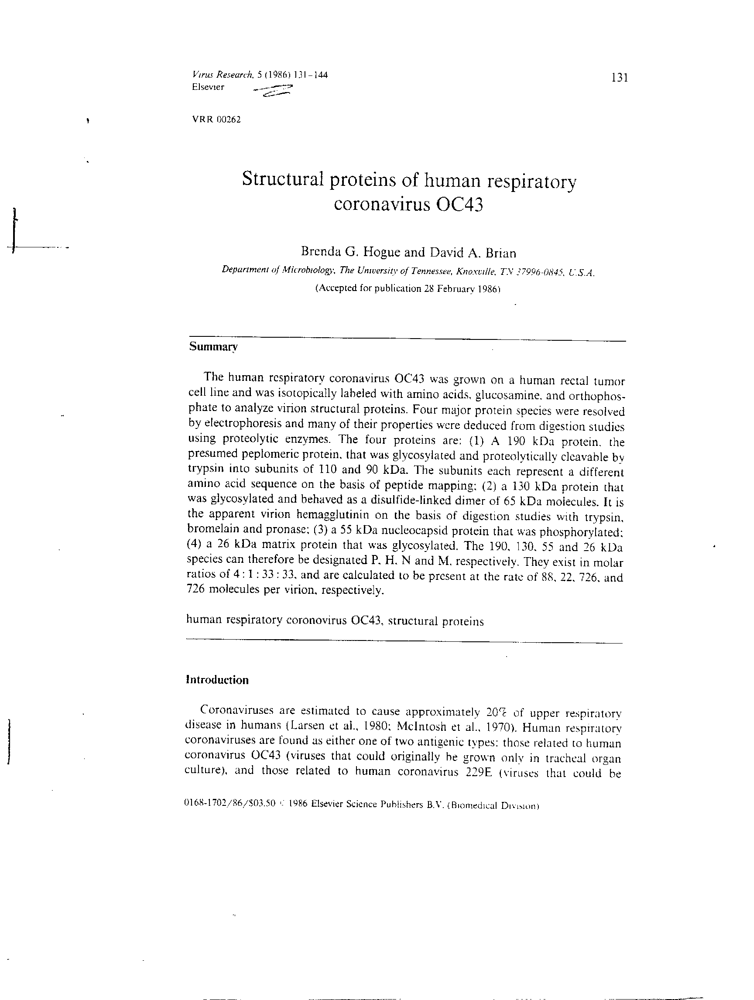

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/images/imagesa/a/a/a/aaa06d00/50486482-6482.tif")
image = image.convert("RGB")
image

In [4]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'Vira Research, $986) 131 BI Benen RR 00262 Structural proteins of human respiratory coronavirus OC43 Brenda G. Hogue and David A. Brian Deparment of Micrbolgs, The Unies of Tennesse, Kosei, TY 27996 0845. US A (Accepted for publication 28 February 1986) Summary The human respiratory coronavirus OC43 was grown on a human rectal tumor cell line and was isotopically labeled with amino acids, glucosamine. and orthophos- phate to analyze virion structural proteins. Four major protein species were resolved by electrophoresis and many of their properties were deduced from digestion studies using proteolytic enzymes. The four proteins ace: (1) A 190 kDa protein. the presumed peplomeric protein, that was glycosylated and proteolytically cleavable by {uypsin into subunits of 110 and 90 kDa. The subunits each represent @ different amino acid sequence on the basis of peptide mapping: (2) a 130 kDa protein that was slycosvlated and behaved as a disulfide-linked dimer of 65 kDa molecules. Its the a

In [5]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [6]:
encoded_inputs = processor(image, return_tensors='pt', padding="max_length", truncation=True)

In [7]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 512])
bbox torch.Size([1, 512, 4])
token_type_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])
image torch.Size([1, 3, 224, 224])


In [8]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

'[CLS] vira research, $ 986 ) 131 bi benen rr 00262 structural proteins of human respiratory coronavirus oc43 brenda g. hogue and david a. brian deparment of micrbolgs, the unies of tennesse, kosei, ty 27996 0845. us a ( accepted for publication 28 february 1986 ) summary the human respiratory coronavirus oc43 was grown on a human rectal tumor cell line and was isotopically labeled with amino acids, glucosamine. and orthophos - phate to analyze virion structural proteins. four major protein species were resolved by electrophoresis and many of their properties were deduced from digestion studies using proteolytic enzymes. the four proteins ace : ( 1 ) a 190 kda protein. the presumed peplomeric protein, that was glycosylated and proteolytically cleavable by { uypsin into subunits of 110 and 90 kda. the subunits each represent @ different amino acid sequence on the basis of peptide mapping : ( 2 ) a 130 kda protein that was slycosvlated and behaved as a disulfide - linked dimer of 65 kda 

In [9]:
labels = ['budget', 'scientific_report', 'specification', 'letter', 'presentation',
          'questionnaire', 'form', 'memo', 'email', 'news_article',
          'file_folder', 'invoice', 'advertisement', 'scientific_publication', 'resume']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'advertisement': 12,
 'budget': 0,
 'email': 8,
 'file_folder': 10,
 'form': 6,
 'invoice': 11,
 'letter': 3,
 'memo': 7,
 'news_article': 9,
 'presentation': 4,
 'questionnaire': 5,
 'resume': 14,
 'scientific_publication': 13,
 'scientific_report': 1,
 'specification': 2}

In [10]:
raw_label2id = {0: 'letter', 1: 'form', 2: 'email', 3: 'handwritten', 4: 'advertisement',
                5: 'scientific_report', 6: 'scientific_publication', 7: 'specification', 8: 'file_folder', 9: 'news_article',
                10: 'budget', 11: 'invoice', 12: 'presentation', 13: 'questionnaire', 14: 'resume', 15: 'memo'}

In [11]:
from pandas.core.frame import DataFrame
import pandas as pd
import os

def create_dataset_df(image_dir, label_file_path):
    df_dataset = pd.read_csv(label_file_path, header=None, names=['image_path', 'label'], delimiter=' ')
    df_dataset['image_path'] = df_dataset['image_path'].apply(lambda img_p: os.path.join(image_dir, img_p))
    df_dataset['label'] = df_dataset['label'].apply(lambda x: raw_label2id[x])
    df_dataset = df_dataset[df_dataset['label'] != 'handwritten']
    df_dataset['label_id'] = df_dataset['label'].apply(lambda label: label2id[label])
    df_dataset.reset_index(drop=True, inplace=True)
    return df_dataset

In [12]:
image_dir = '/content/images'

train_dataset_df = create_dataset_df(image_dir=image_dir,
                                     label_file_path='/content/labels/train.txt')
val_dataset_df = create_dataset_df(image_dir=image_dir,
                                     label_file_path='/content/labels/val.txt')
test_dataset_df = create_dataset_df(image_dir=image_dir,
                                     label_file_path='/content/labels/test.txt')

In [13]:
train_dataset_df = train_dataset_df.loc[:100]

In [14]:
import os
from torch.utils.data import Dataset
import torch
from PIL import Image

class CDIPDataset(Dataset):
    def __init__(self, df_dataset, processor=None, max_length=512):
        """
        Args:
            df_dataset : Dataframe containing the image_path + label
            processor (LayoutLMv2Processor): Processor to prepare the text + image
        """
        self.df_dataset = df_dataset
        self.processor = processor
    
    def __len__(self):
        return len(self.df_dataset.index)
    
    def __getitem__(self, idx):
        image = Image.open(self.df_dataset.loc[idx]['image_path'])
        image = image.convert("RGB")
        encoded_inputs = processor(image, padding="max_length", truncation=True, return_tensors='pt')
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()
        
        # add labels
        encoded_inputs['labels'] = torch.LongTensor([self.df_dataset.loc[idx]['label_id']])
        
        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([1])

        return encoded_inputs

In [15]:
train_dataset = CDIPDataset(df_dataset=train_dataset_df,
                           processor=processor)
val_dataset = CDIPDataset(df_dataset=val_dataset_df,
                           processor=processor)
test_dataset = CDIPDataset(df_dataset=test_dataset_df,
                           processor=processor)

In [16]:
import torch

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=6)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([6, 512])
bbox torch.Size([6, 512, 4])
token_type_ids torch.Size([6, 512])
attention_mask torch.Size([6, 512])
image torch.Size([6, 3, 224, 224])
labels torch.Size([6, 1])


In [18]:
processor.tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] seuillard memorandum. to : j. d. heck from : a. p. deaton subject : solubility of materials for acute cardiovascular and respiratory studies according to the sop for the determination of solubility of materials for acute cardiovascular and respiratory effects study in beagle dogs, the solubilities of the most recently tested materials are provided as follows : a. soluble according to this sop : b61, b199. onmilis. 2 destin r. b. deaton jeb : xe : e. w. crouse tzsse008 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [19]:
id2label[batch['labels'][0].item()]

'memo'

In [20]:
len(labels)

15

# Define the model

In [21]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", 
                                                            num_labels=len(labels))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.3.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.10.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.19.conv3.norm.num_batches_tra

LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [22]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 5
t_total = len(train_dataset) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
    print("Epoch:", epoch)
    running_loss = 0.0
    correct = 0
    for batch in tqdm(train_dataloader):
        # forward pass
        input_ids=batch['input_ids'].to(device)
        bbox=batch['bbox'].to(device)
        image=batch['image'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        token_type_ids=batch['token_type_ids'].to(device)
        labels = batch['labels'].squeeze().to(device)
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
        loss = outputs.loss

        running_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        correct += (predictions == labels).float().sum()

        # backward pass to get the gradients 
        loss.backward()

        # update
        optimizer.step()
        optimizer.zero_grad()

        global_step += 1
  
    print("Loss:", running_loss / batch["input_ids"].shape[0])
    accuracy = 100 * correct / len(train_dataset_df.index)
    print("Training accuracy:", accuracy.item())

Epoch: 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss: 9.33251166343689
Training accuracy: 9.900989532470703
Epoch: 1


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss: 7.889445948600769
Training accuracy: 26.73267364501953
Epoch: 2


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss: 6.276321458816528
Training accuracy: 55.4455451965332
Epoch: 3


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss: 4.699269115924835
Training accuracy: 77.22772216796875
Epoch: 4


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:780: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:790: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss: 3.478300142288208
Training accuracy: 83.1683120727539
